In [1]:
import numpy as np
import pandas as pd
import pickle
from os import path
from CSVUtils import *
import matplotlib.pyplot as plt

In [51]:
def plot_benchmark(start_date, end_date, title, add_MDD=False, MDD_thres=None, MDD_window=None,log=True):
    add_mdd = add_MDD and (not MDD_thres is None) and (not MDD_window is None)
    DIR ="./from github/Stock-Trading-Environment/data"
    file_list = ["^BVSP", "^TWII", "^IXIC"]
    price_label = "Price"
    df_list = []

    for file_name in file_list:
        df = csv2df(DIR, file_name+"_new.csv", source="done")
        df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].reset_index(drop = True)
        if add_mdd:
            roll_Max = df[price_label].rolling(window=30, min_periods=1).max()
            df['daily_Drawdown'] = df[price_label]/roll_Max - 1.0
            df['today_below_mdd_thres'] = df['daily_Drawdown'] <= -1*MDD_thres
            df['below_mdd_thres'] = df['today_below_mdd_thres'].rolling(window=MDD_window).agg(lambda x : x.sum())
            df['below_mdd_thres'].fillna(0.0)
        df_list.append(df)

    init_price = np.array([df[price_label][0] for df in df_list])
    init_num = 100000/init_price
    bnh_value = []
    for i in range(len(df_list[0])):
        date = df_list[0]['Date'][i]
        if ((df_list[1]['Date'] == date).any()) and ((df_list[2]['Date'] == date).any()):
            price_arr = np.array([df[df['Date']==date][price_label].values[0] for df in df_list])
            market_value = init_num*price_arr
            avg_value = np.mean(market_value)
            bnh_value.append({
                "Date": date,
                "Value": avg_value
            })

    plt.figure(figsize = (20, 10))

    for i, df in enumerate(df_list):
        if log:
            y = np.log(df[price_label]/df[price_label][0])
        else:
            y = df[price_label]/df[price_label][0]
        moving_avg = pd.Series(y).rolling(window=10).mean().values   
        plt.plot(df['Date'], moving_avg, label = file_list[i])


    bnh_df = pd.DataFrame(bnh_value)
    if log:
        y = np.log(bnh_df['Value']/100000)
    else:
        y = bnh_df['Value']/100000
    moving_avg = pd.Series(y).rolling(window=10).mean().values


    plt.plot(bnh_df['Date'], moving_avg, linewidth=3, label = "Buy and Hold Portfolio")    
    if log:
        plt.axhline(y=0, color = "grey", linestyle='--')
    else:
        plt.axhline(y=1, color = "grey", linestyle='--')

    if add_mdd:
        common_date = df_list[0][df_list[0]['below_mdd_thres']>0]['Date']
        for df in df_list[1:]:
            common_date = np.intersect1d(common_date, (df[df['below_mdd_thres']>0]['Date']))
        all_date = pd.DataFrame(df_list[0]['Date'])
        states={
            "In": 0,
            "Start_Out": 1,
            "Out": 2,
            "End_Out": 3
        }

        all_date['Out'] = np.isin(all_date['Date'], list(common_date))
        all_date['Prev_Out'] = all_date['Out'].shift()
        all_date.loc[0, 'Prev_Out'] = False
        plot_df = all_date[all_date['Out'] | all_date['Prev_Out']]

        date_range_list = []
        default_range = {"start": None, "end": None}
        current_range = dict(default_range)
        for row in plot_df.iterrows():
            if row[1]['Out'] == True and row[1]['Prev_Out'] == False:
                current_range['start'] = row[1]['Date']
            if row[1]['Out'] == False and row[1]['Prev_Out'] == True:
                current_range['end'] = row[1]['Date']
                date_range_list.append(current_range)
                current_range = dict(default_range)
        for date_range in date_range_list:
            plt.axvspan(date_range['start'], date_range['end'], color='red', alpha=0.5)
#     print(date_range_list)
    plt.xlabel("Date")
    plt.ylabel("Log Market Value")
    plt.title(title)
    plt.legend()
    plt.show()

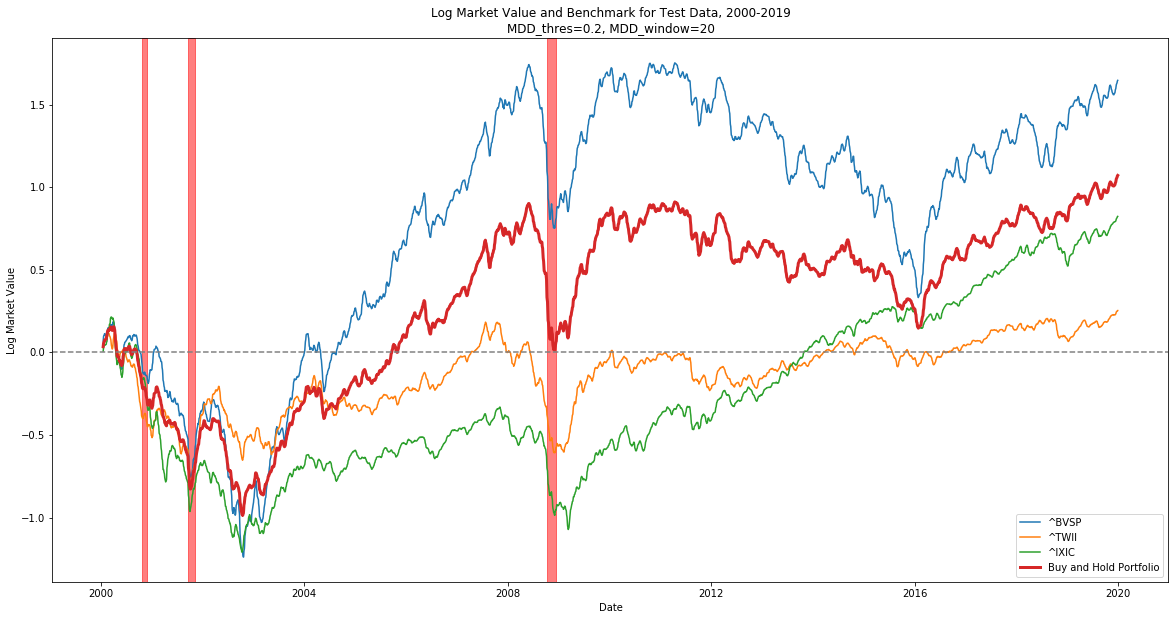

In [42]:
start_date = pd.to_datetime("2000-01-01")
end_date = pd.to_datetime("2019-12-31")

plot_benchmark(start_date, end_date, "Log Market Value and Benchmark for Test Data, 2000-2019\nMDD_thres=0.2, MDD_window=20",
               add_MDD=True, MDD_thres=0.2, MDD_window=20)

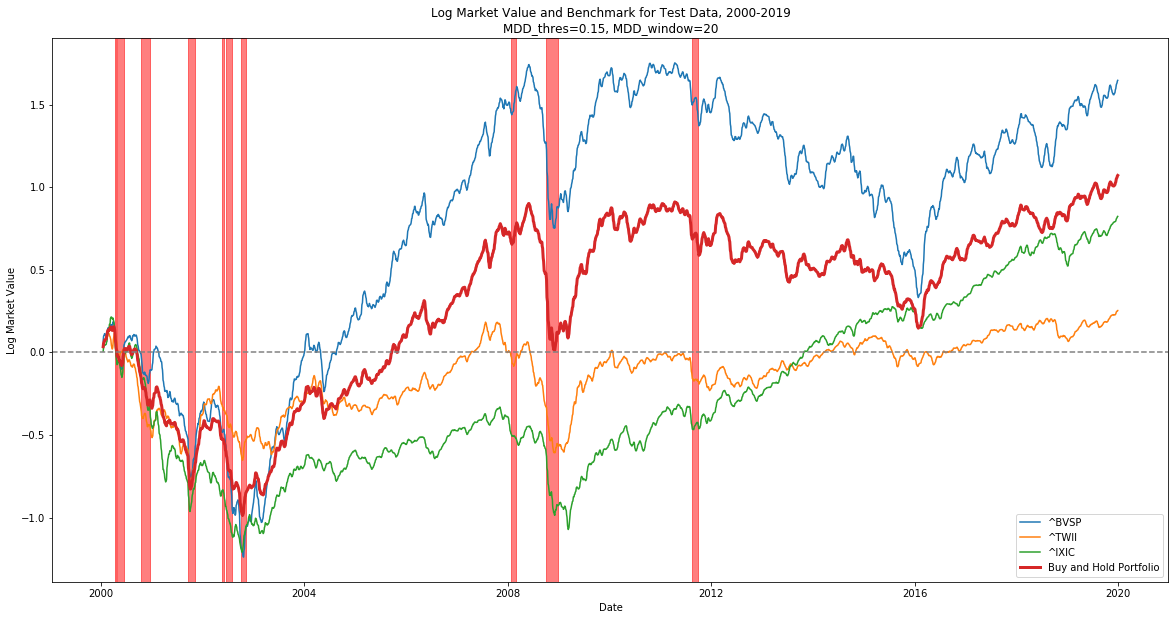

In [43]:
start_date = pd.to_datetime("2000-01-01")
end_date = pd.to_datetime("2019-12-31")

plot_benchmark(start_date, end_date, "Log Market Value and Benchmark for Test Data, 2000-2019\nMDD_thres=0.15, MDD_window=20",
               add_MDD=True, MDD_thres=0.15, MDD_window=20)

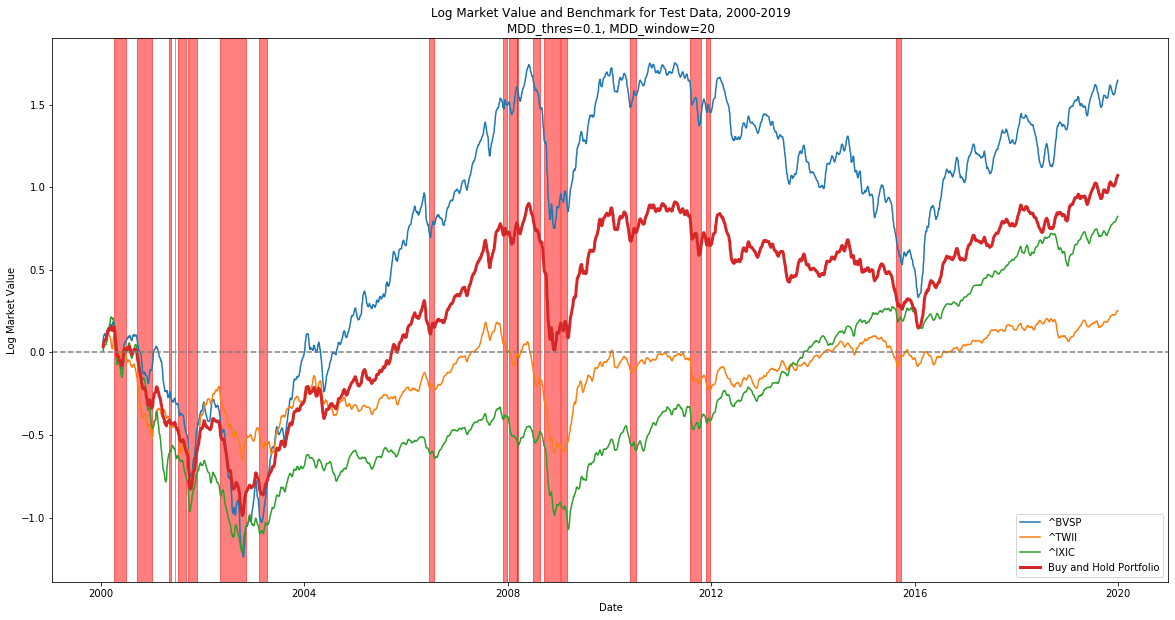

In [44]:
start_date = pd.to_datetime("2000-01-01")
end_date = pd.to_datetime("2019-12-31")

plot_benchmark(start_date, end_date, "Log Market Value and Benchmark for Test Data, 2000-2019\nMDD_thres=0.1, MDD_window=20",
               add_MDD=True, MDD_thres=0.1, MDD_window=20)

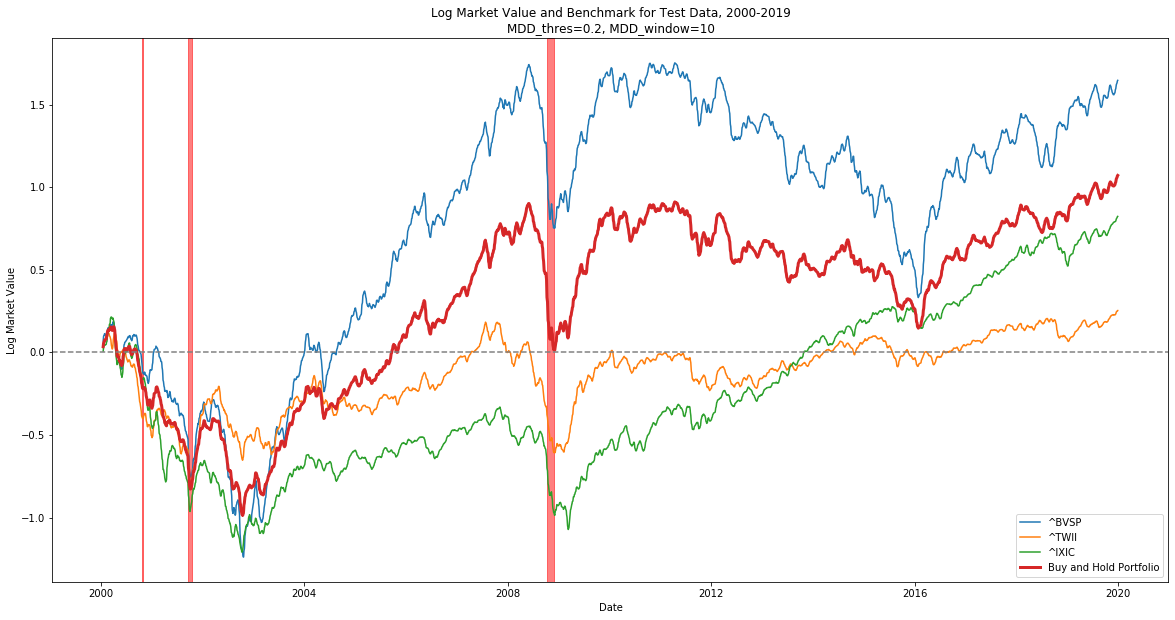

In [45]:
# Actual Price, 30
start_date = pd.to_datetime("2000-01-01")
end_date = pd.to_datetime("2019-12-31")

plot_benchmark(start_date, end_date, "Log Market Value and Benchmark for Test Data, 2000-2019\nMDD_thres=0.2, MDD_window=10",
               add_MDD=True, MDD_thres=0.2, MDD_window=10)

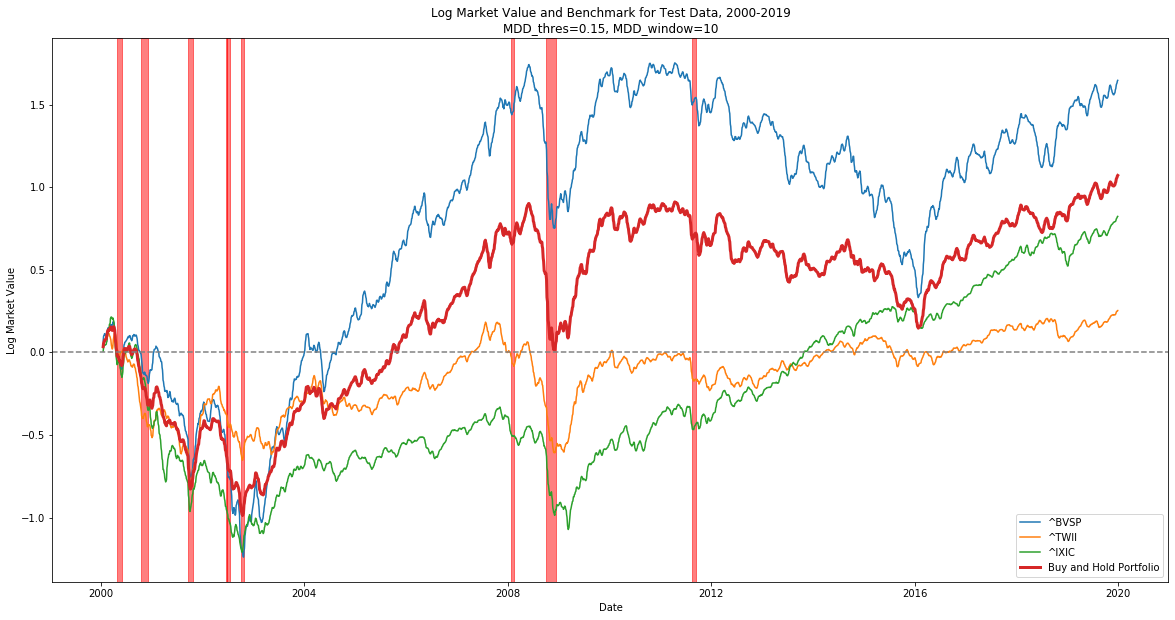

In [46]:
start_date = pd.to_datetime("2000-01-01")
end_date = pd.to_datetime("2019-12-31")

plot_benchmark(start_date, end_date, "Log Market Value and Benchmark for Test Data, 2000-2019\nMDD_thres=0.15, MDD_window=10",
               add_MDD=True, MDD_thres=0.15, MDD_window=10)

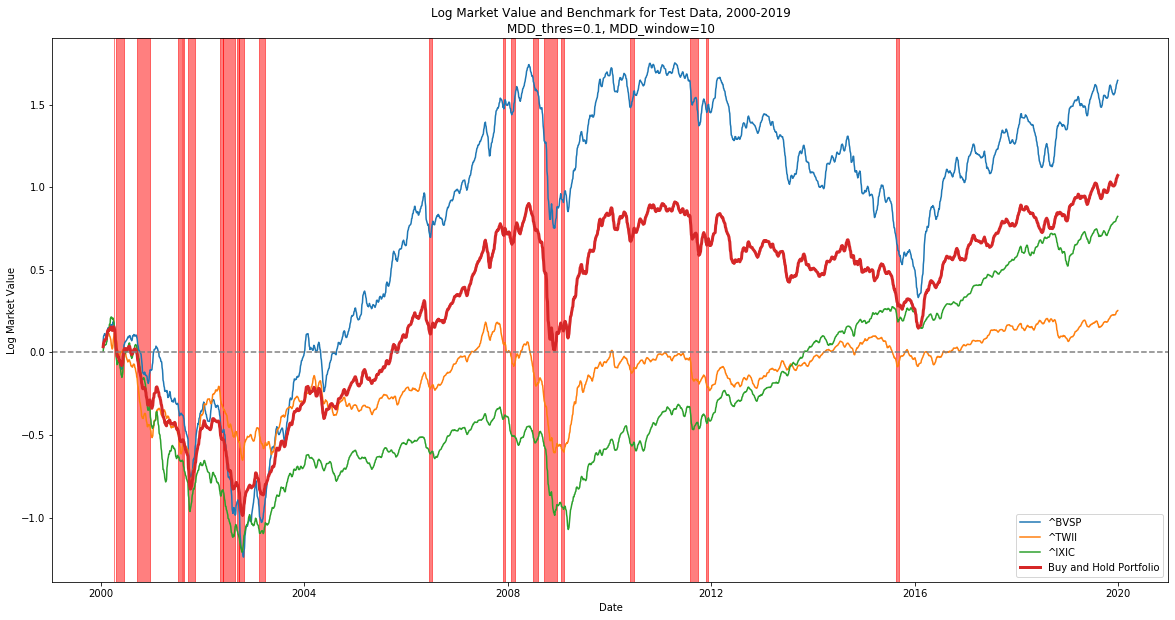

In [47]:
start_date = pd.to_datetime("2000-01-01")
end_date = pd.to_datetime("2019-12-31")

plot_benchmark(start_date, end_date, "Log Market Value and Benchmark for Test Data, 2000-2019\nMDD_thres=0.1, MDD_window=10",
               add_MDD=True, MDD_thres=0.1, MDD_window=10)

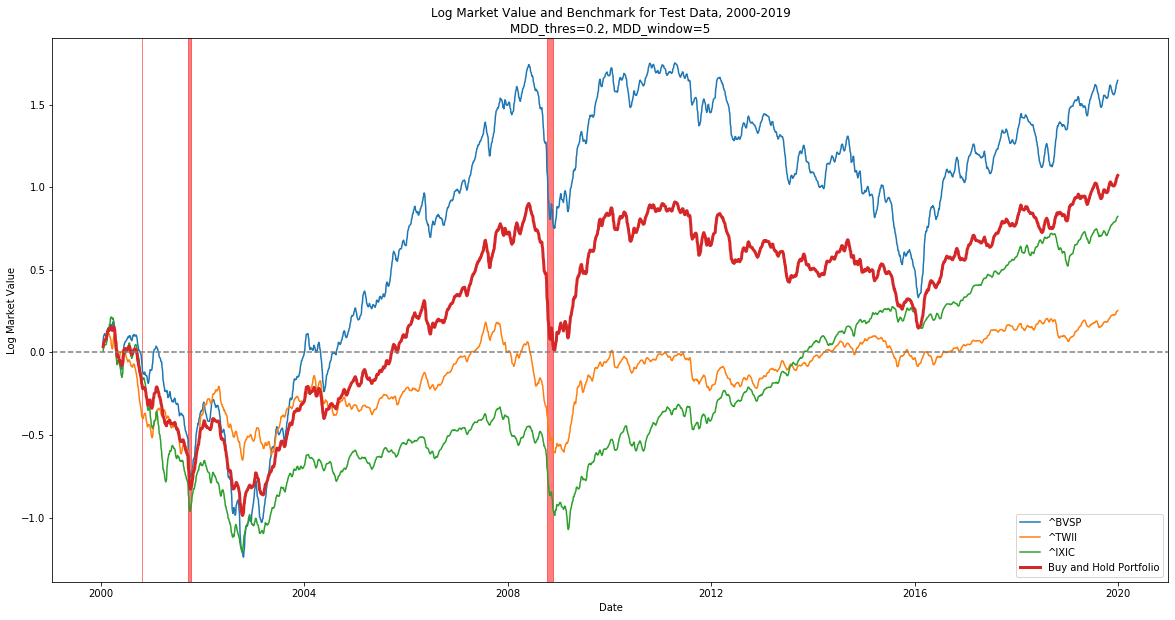

In [48]:
start_date = pd.to_datetime("2000-01-01")
end_date = pd.to_datetime("2019-12-31")

plot_benchmark(start_date, end_date, "Log Market Value and Benchmark for Test Data, 2000-2019\nMDD_thres=0.2, MDD_window=5",
               add_MDD=True, MDD_thres=0.2, MDD_window=5)

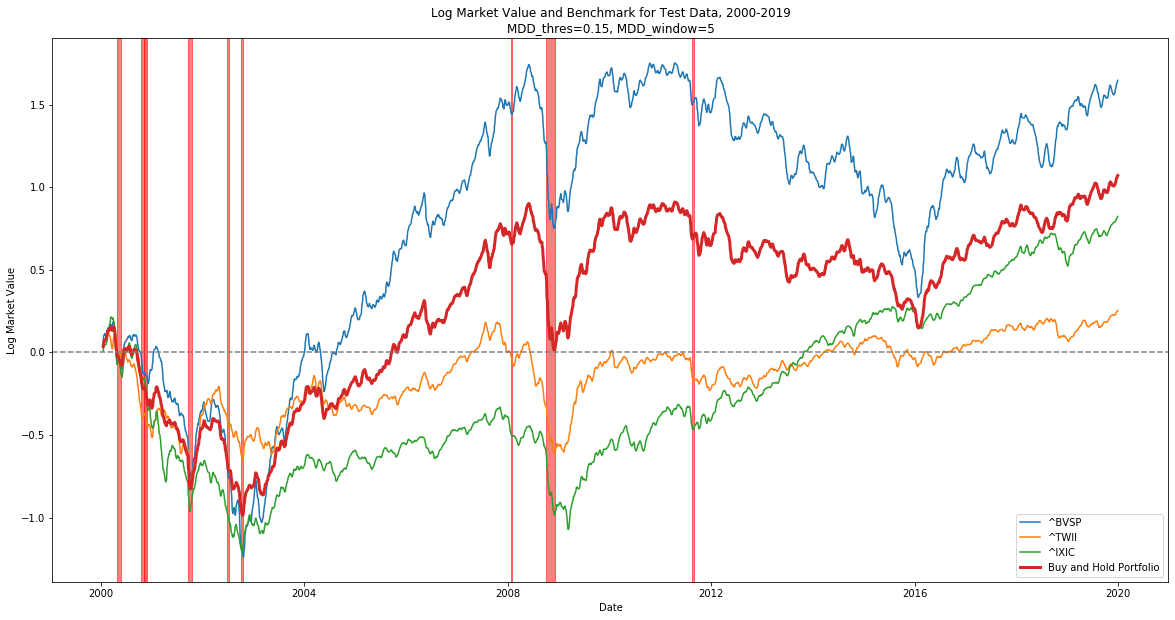

In [49]:
start_date = pd.to_datetime("2000-01-01")
end_date = pd.to_datetime("2019-12-31")

plot_benchmark(start_date, end_date, "Log Market Value and Benchmark for Test Data, 2000-2019\nMDD_thres=0.15, MDD_window=5",
               add_MDD=True, MDD_thres=0.15, MDD_window=5)

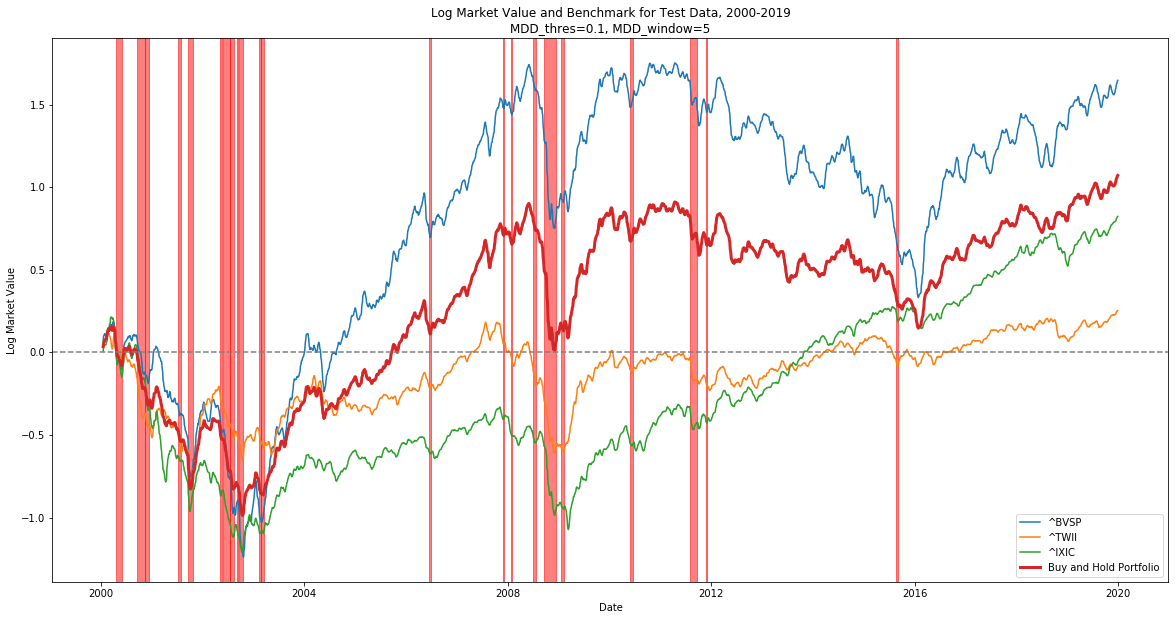

In [50]:
start_date = pd.to_datetime("2000-01-01")
end_date = pd.to_datetime("2019-12-31")

plot_benchmark(start_date, end_date, "Log Market Value and Benchmark for Test Data, 2000-2019\nMDD_thres=0.1, MDD_window=5",
               add_MDD=True, MDD_thres=0.1, MDD_window=5)

In [ ]:
start_date = pd.to_datetime("2000-01-01")
end_date = pd.to_datetime("2019-12-31")

plot_benchmark(start_date, end_date, "Log Market Value and Benchmark for Test Data, 2000-2019")

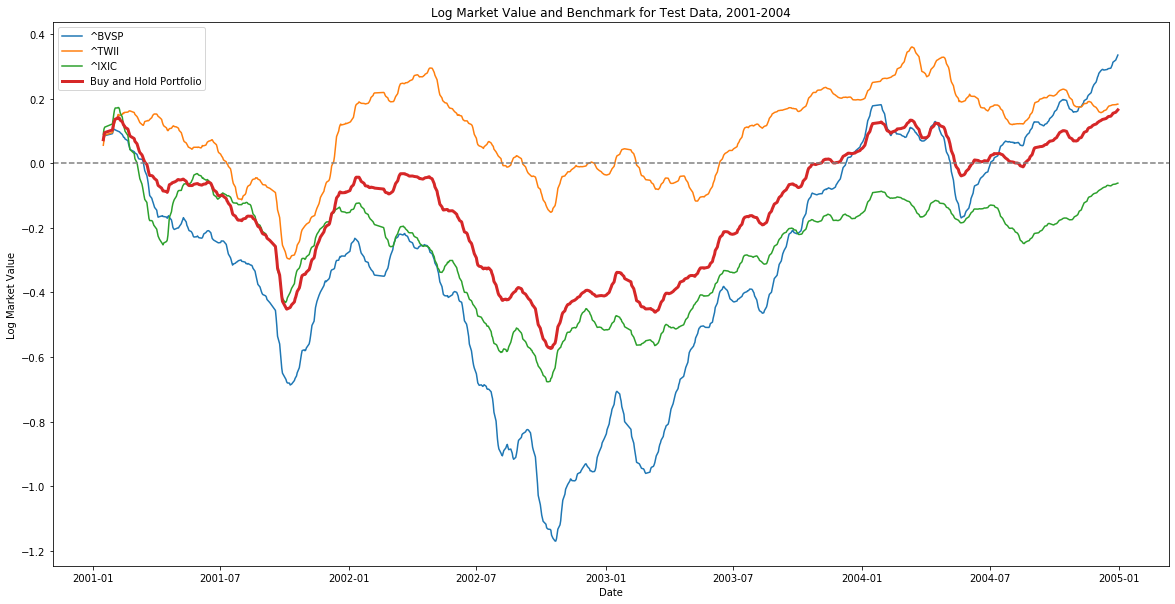

In [16]:
start_date = pd.to_datetime("2001-01-01")
end_date = pd.to_datetime("2004-12-31")

plot_benchmark(start_date, end_date, "Log Market Value and Benchmark for Test Data, 2001-2004",
               log=True)

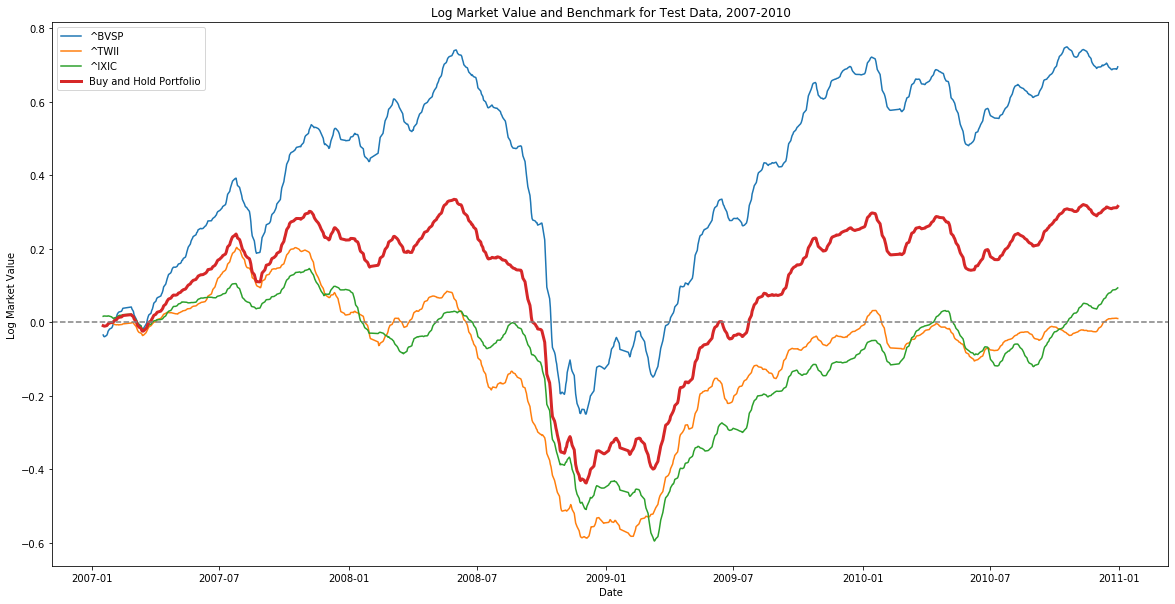

In [17]:
start_date = pd.to_datetime("2007-01-01")
end_date = pd.to_datetime("2010-12-31")

plot_benchmark(start_date, end_date, "Log Market Value and Benchmark for Test Data, 2007-2010",
               log=True)

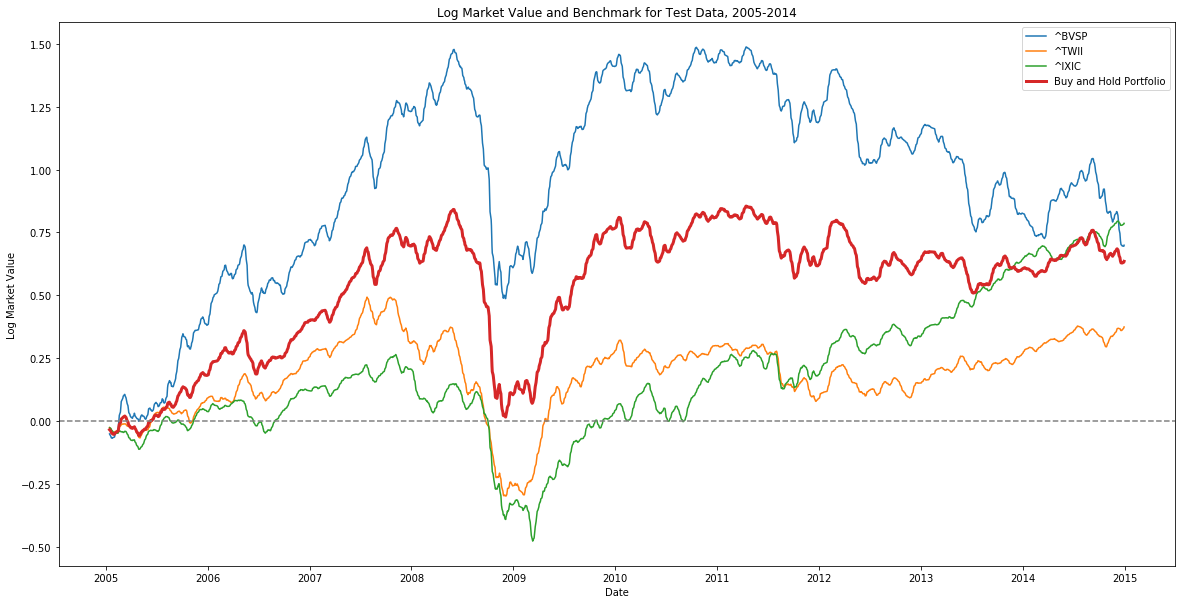

In [18]:
start_date = pd.to_datetime("2005-01-01")
end_date = pd.to_datetime("2014-12-31")

plot_benchmark(start_date, end_date, "Log Market Value and Benchmark for Test Data, 2005-2014",
               log=True)

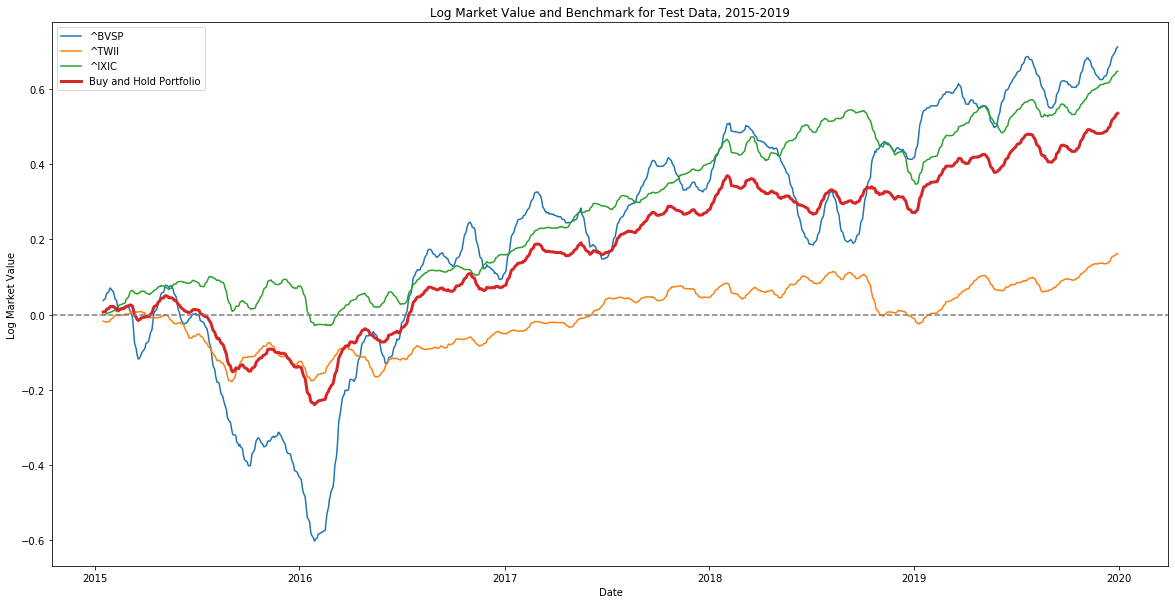

In [19]:
start_date = pd.to_datetime("2015-01-01")
end_date = pd.to_datetime("2019-12-31")

plot_benchmark(start_date, end_date, "Log Market Value and Benchmark for Test Data, 2015-2019",
               log=True)

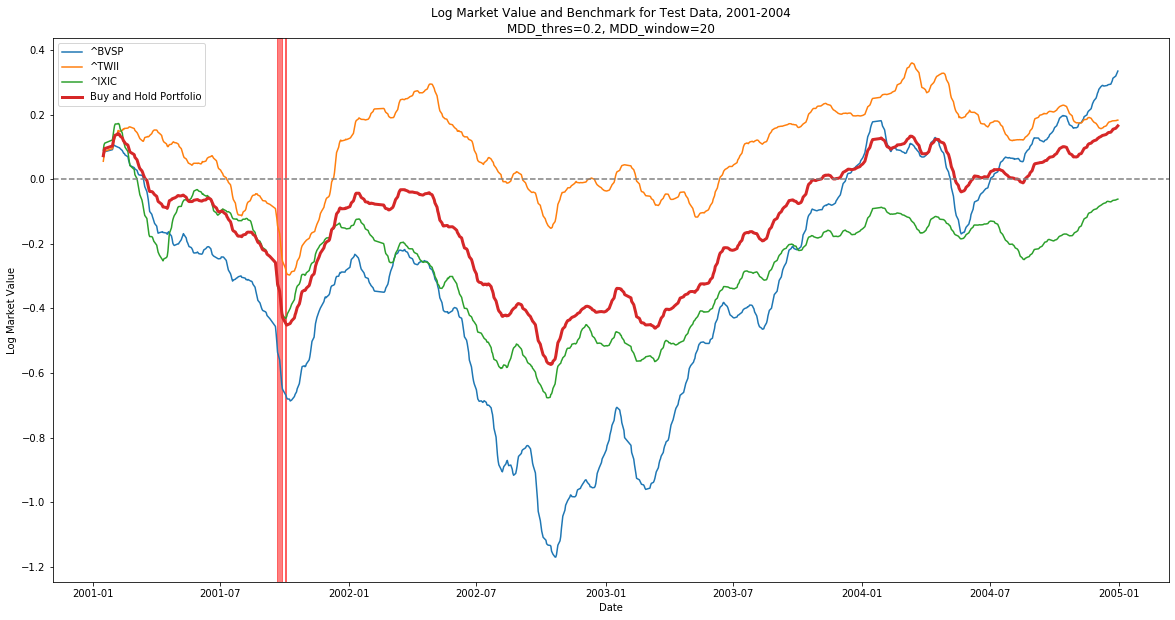

In [110]:
start_date = pd.to_datetime("2001-01-01")
end_date = pd.to_datetime("2004-12-31")

plot_benchmark(start_date, end_date, "Log Market Value and Benchmark for Test Data, 2001-2004\nMDD_thres=0.2, MDD_window=20",
               add_MDD=True, MDD_thres=0.2, MDD_window=20, log=True)

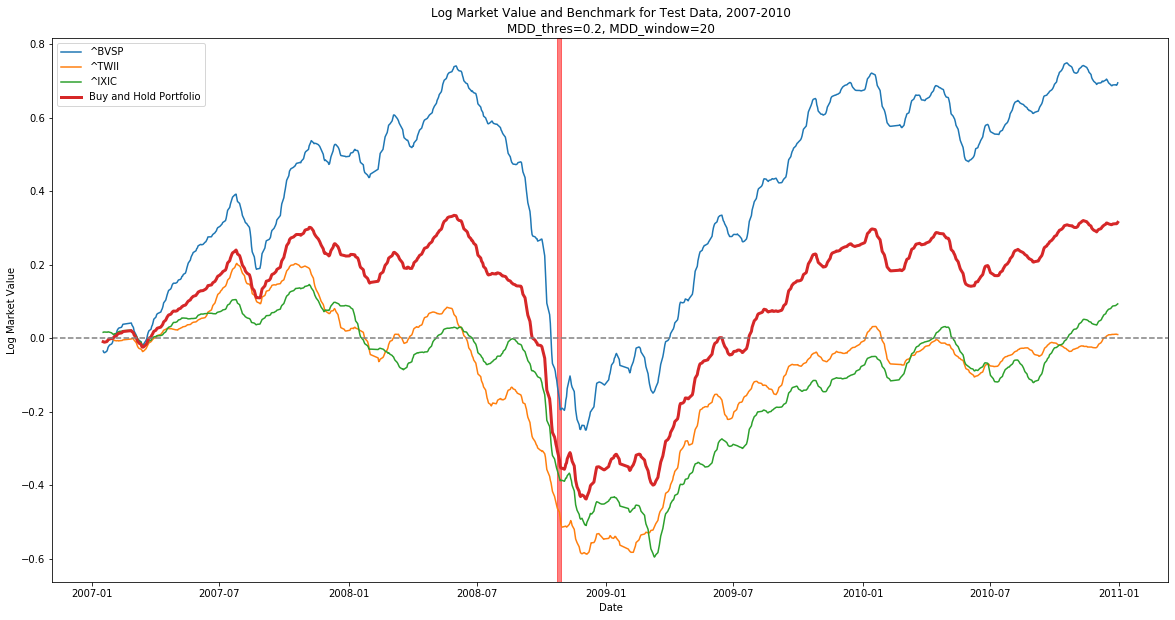

In [111]:
start_date = pd.to_datetime("2007-01-01")
end_date = pd.to_datetime("2010-12-31")

plot_benchmark(start_date, end_date, "Log Market Value and Benchmark for Test Data, 2007-2010\nMDD_thres=0.2, MDD_window=20",
               add_MDD=True, MDD_thres=0.2, MDD_window=20, log=True)

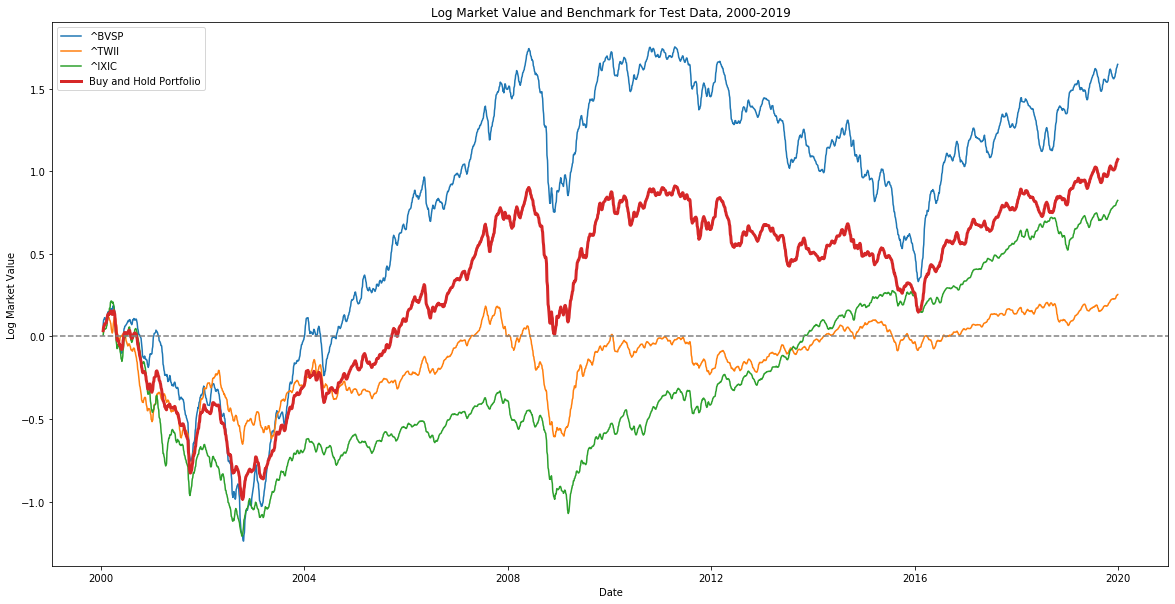

In [84]:
start_date = pd.to_datetime("2000-01-01")
end_date = pd.to_datetime("2019-12-31")

plot_benchmark(start_date, end_date, "Log Market Value and Benchmark for Test Data, 2000-2019")

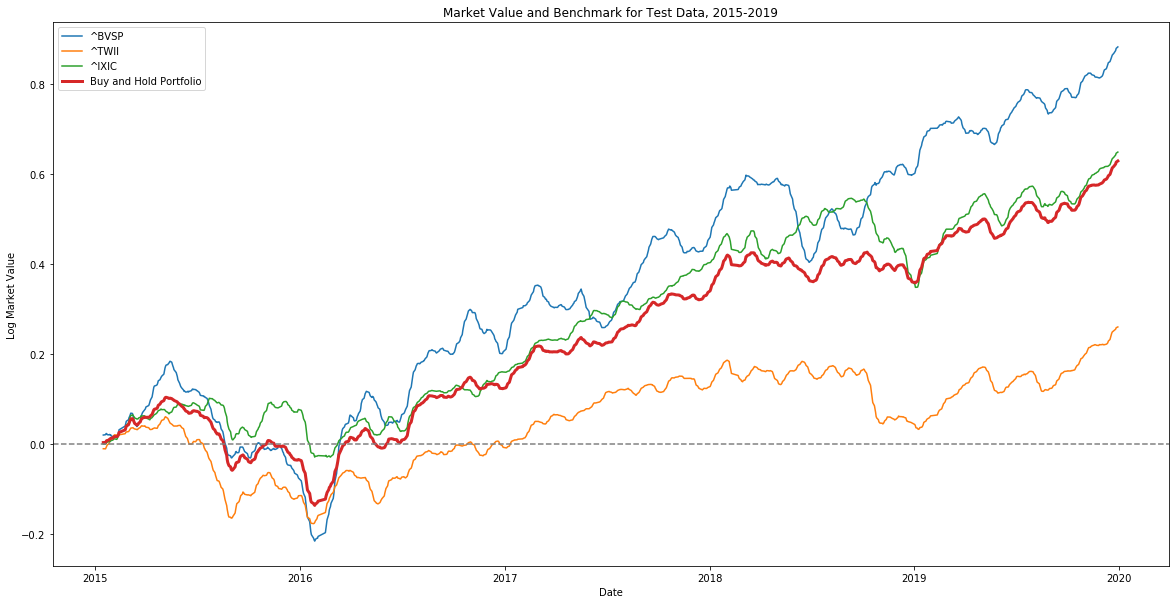

In [102]:
start_date = pd.to_datetime("2015-01-01")
end_date = pd.to_datetime("2019-12-31")

plot_benchmark(start_date, end_date, "Market Value and Benchmark for Test Data, 2015-2019")

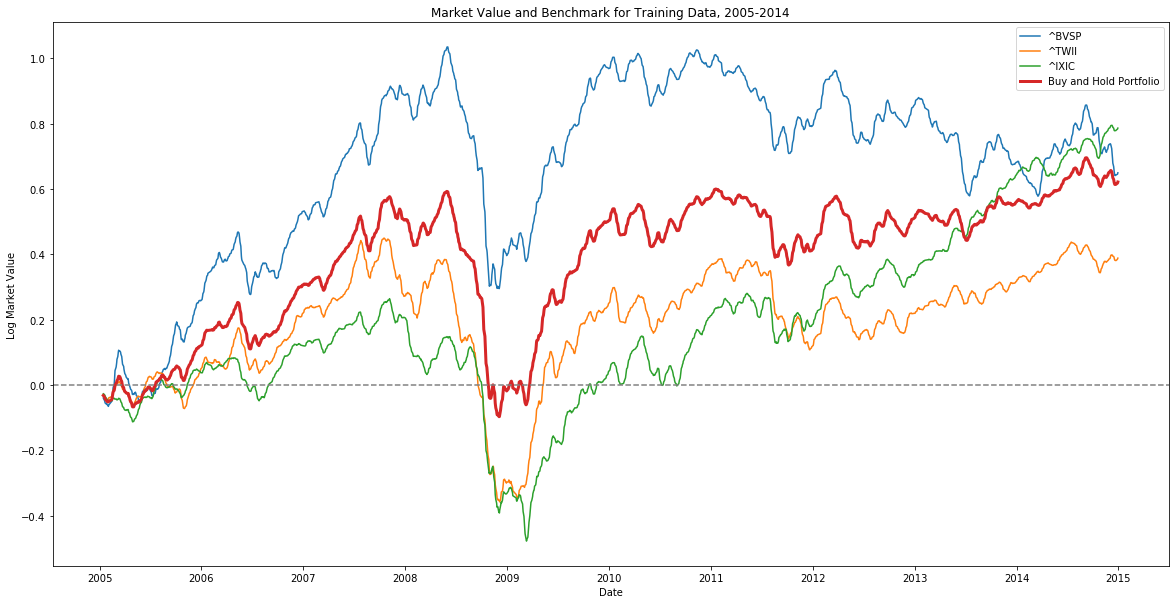

In [103]:
start_date = pd.to_datetime("2005-01-01")
end_date = pd.to_datetime("2014-12-31")

plot_benchmark(start_date, end_date, "Market Value and Benchmark for Training Data, 2005-2014")

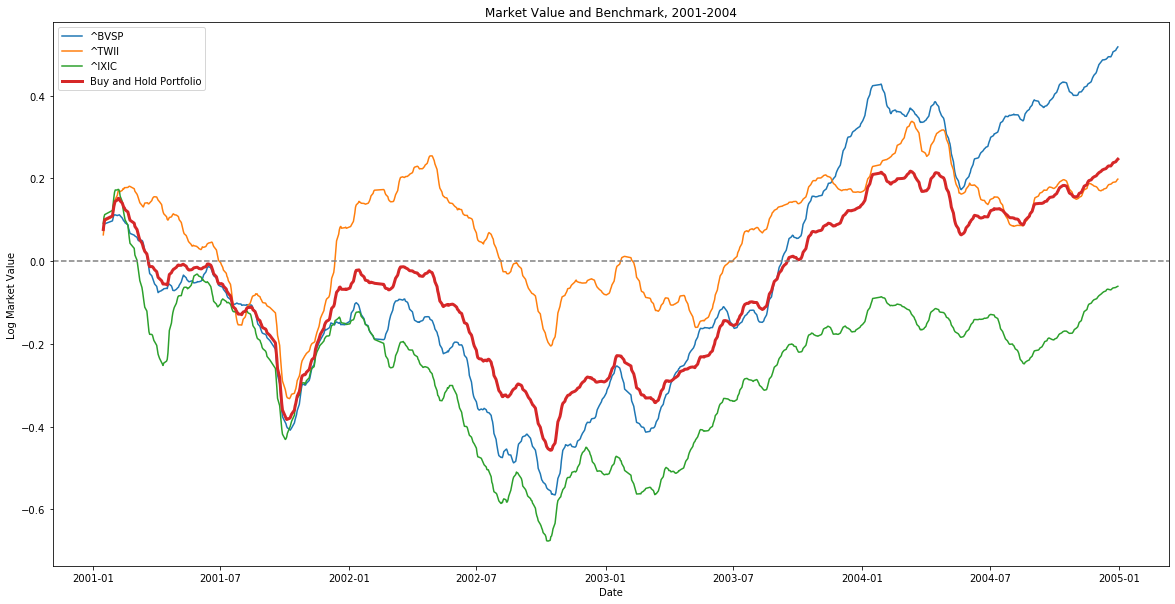

In [104]:
start_date = pd.to_datetime("2001-01-01")
end_date = pd.to_datetime("2004-12-31")

plot_benchmark(start_date, end_date, "Market Value and Benchmark, 2001-2004")

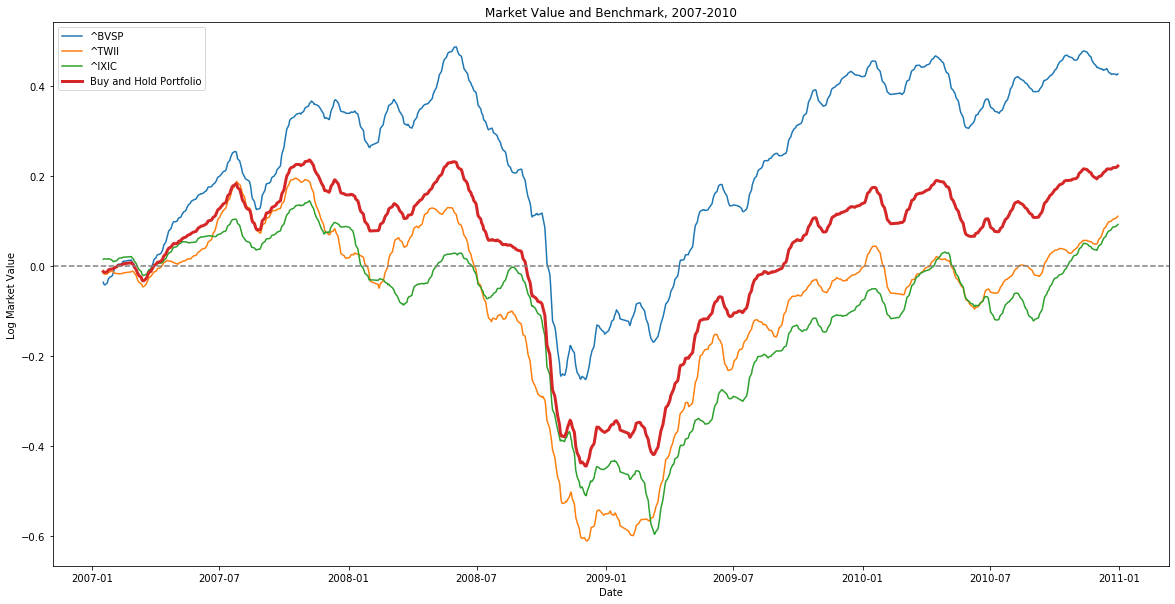

In [105]:
start_date = pd.to_datetime("2007-01-01")
end_date = pd.to_datetime("2010-12-31")

plot_benchmark(start_date, end_date, "Market Value and Benchmark, 2007-2010")

In [79]:
DIR ="./from github/Stock-Trading-Environment/data"
file_list = ["^BVSP", "^TWII", "^IXIC"]

start_date = pd.to_datetime("2015-01-01")
end_date = pd.to_datetime("2019-12-31")

df_list = []

for file_name in file_list:
    df = csv2df(DIR, file_name+"_new.csv", source="done")
    df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].reset_index(drop = True)
    df_list.append(df)

In [80]:
init_price = np.array([df['Price'][0] for df in df_list])
init_num = 100000/init_price
bnh_value = []
for i in range(len(df_list[0])):
    date = df_list[0]['Date'][i]
    if ((df_list[1]['Date'] == date).any()) and ((df_list[2]['Date'] == date).any()):
        price_arr = np.array([df[df['Date']==date]['Price'].values[0] for df in df_list])
        market_value = init_num*price_arr
        avg_value = np.mean(market_value)
        bnh_value.append({
            "Date": date,
            "Value": avg_value
        })

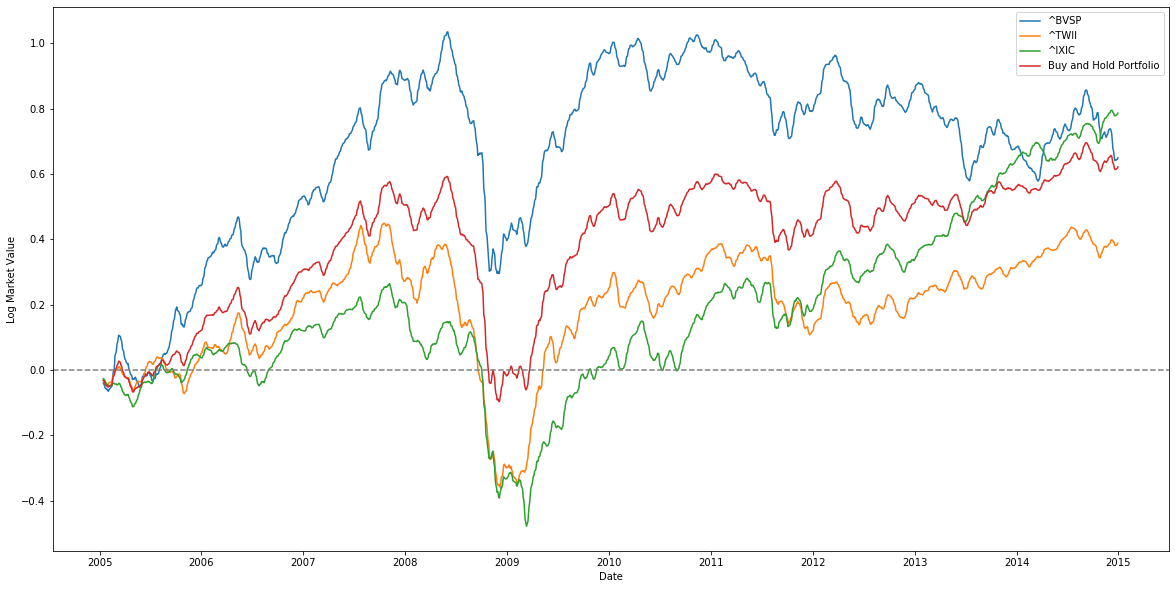

In [78]:
plt.figure(figsize = (20, 10))

for i, df in enumerate(df_list):
    y = np.log(df['Price']/df['Price'][0])
    moving_avg = pd.Series(y).rolling(window=10).mean().values   
    plt.plot(df['Date'], moving_avg, label = file_list[i])

    
bnh_df = pd.DataFrame(bnh_value)
y = np.log(bnh_df['Value']/100000)
moving_avg = pd.Series(y).rolling(window=10).mean().values

plt.plot(bnh_df['Date'], moving_avg, label = "Buy and Hold Portfolio")    
plt.axhline(y=0, color = "grey", linestyle='--')
plt.xlabel("Date")
plt.ylabel("Log Market Value")
plt.legend()
plt.show()